# Gold Price Prediction Using ARIMA Model

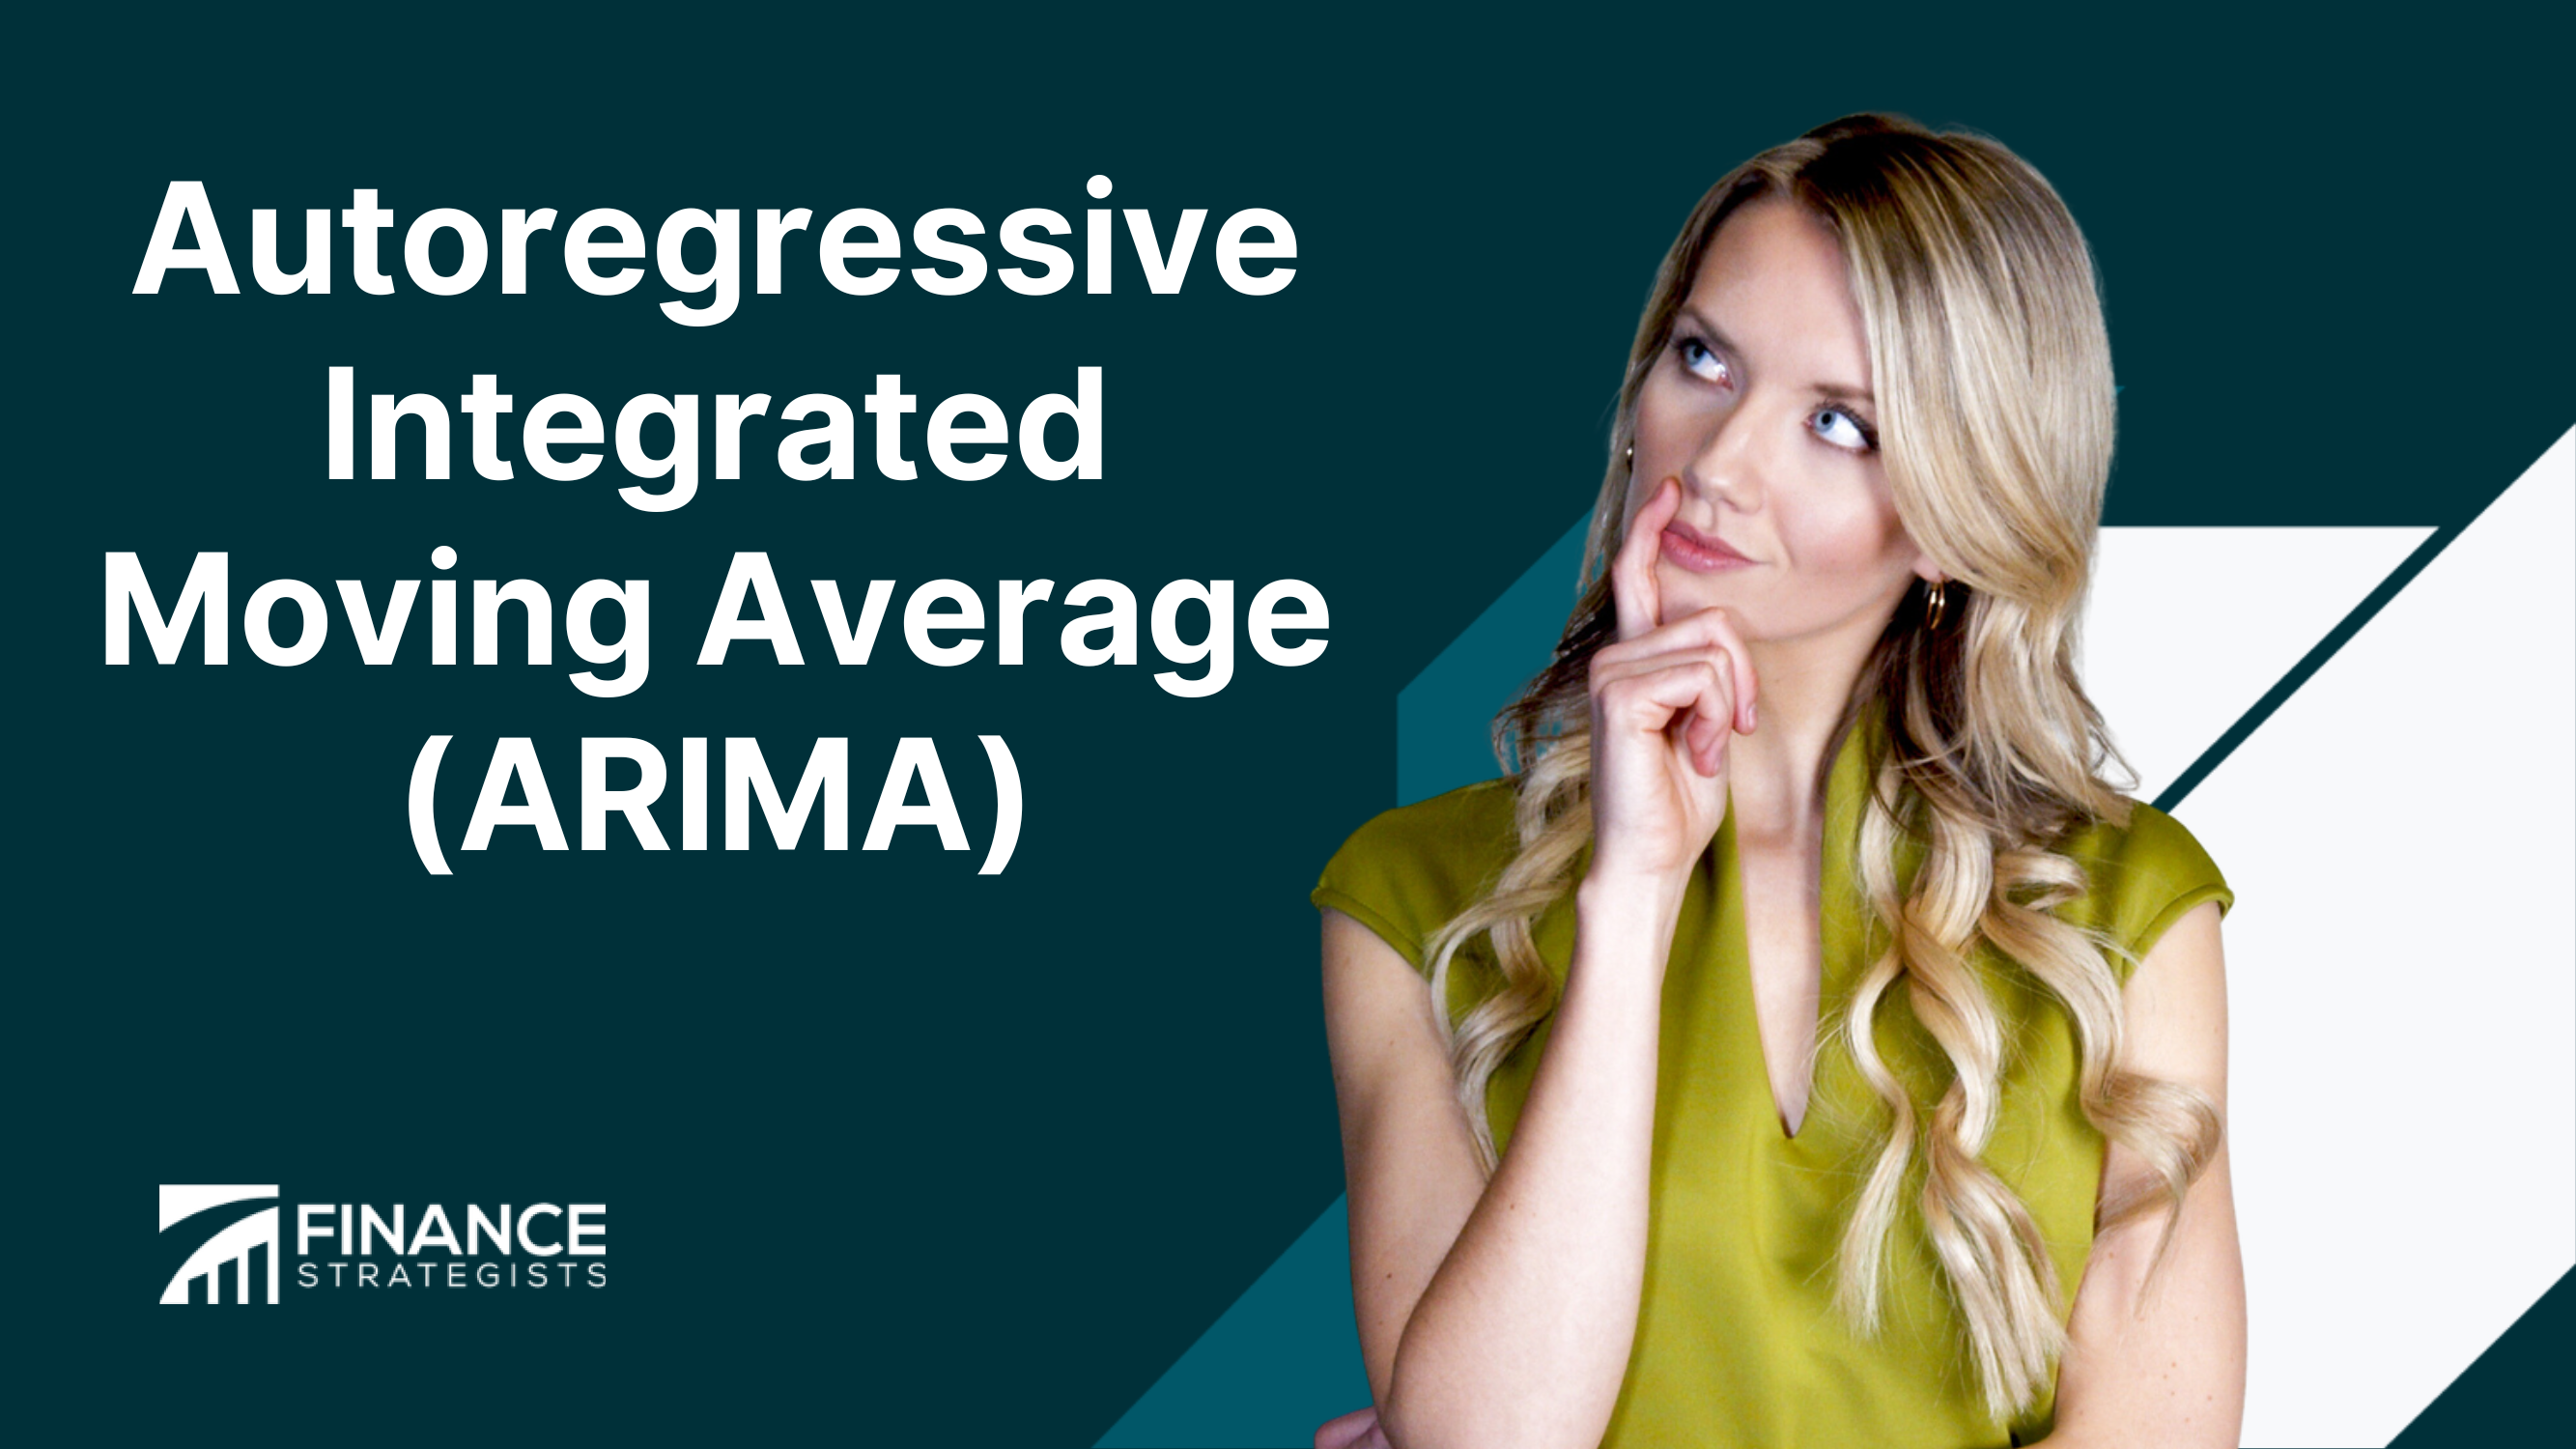

<div style="background-color:#d5eae9; padding:20px; font-size:15px">
    <h2> What is ARIMA used for?</h2>
<h3> ARIMA is a method for forecasting or predicting future outcomes based on a historical time series. It is based on the statistical concept of serial correlation, where past data points influence future data points.</h3>


# Importing the libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.dates as mdates
import datetime

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from math import sqrt


## Read CV File

In [2]:
# Read the data from a CSV file
data = pd.read_csv('XAUUSD.csv')


In [3]:
# make a Data-Frame
df = pd.DataFrame(data)

# Missing Values

In [4]:
# how many missing values are in the Data-Frame?
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 622 entries, 0 to 621
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          622 non-null    object 
 1   Open          622 non-null    float64
 2   High          622 non-null    float64
 3   Low           622 non-null    float64
 4   Close         622 non-null    float64
 5   Change(Pips)  622 non-null    int64  
 6   Change(%)     622 non-null    float64
dtypes: float64(5), int64(1), object(1)
memory usage: 34.1+ KB


In [5]:
df.isnull().sum()

Date            0
Open            0
High            0
Low             0
Close           0
Change(Pips)    0
Change(%)       0
dtype: int64

## Understanding the Dataset



In [6]:
# to draw a Time-Series chart of Close vs. Date, we make a new Data-Frame containing only 2 columns of Date & Close
df2 = df

### Convert Date column to datetime format

In [7]:
# convert date string to date time format in a new variable (df_date)
df_date = pd.to_datetime(df2['Date'], format='%m/%d/%Y', infer_datetime_format=True)

In [8]:
# delete the old date column and replace the new date column
df2 = df2.drop('Date', axis=1)
df2.insert(0, 'Date', df_date, allow_duplicates=False)

In [9]:
# first 5 samples of new Data-Frame
df2.head(5)

,Date,Open,High,Low,Close,Change(Pips),Change(%)
0,2023-07-04,1921.07,1930.22,1920.34,1929.65,858,0.44
1,2023-07-03,1917.70,1930.50,1910.11,1921.17,347,0.18
2,2023-07-02,1920.30,1920.30,1917.50,1917.70,-260,-0.14
3,2023-06-30,1908.71,1922.61,1900.57,1919.20,1049,0.55
4,2023-06-29,1909.47,1913.00,1893.16,1908.76,-71,-0.04


In [10]:
# sorting the Data-Frame values by Date
df2.sort_values(by='Date', inplace=True)

In [11]:
# first 5 samples of new Data-Frame after sorting...
df2.head(5)

,Date,Open,High,Low,Close,Change(Pips),Change(%)
621,2021-07-04,1787.22,1787.73,1785.00,1786.39,-83,-0.05
620,2021-07-05,1786.68,1794.00,1783.80,1791.15,447,0.25
619,2021-07-06,1790.85,1814.89,1789.89,1795.68,483,0.27
618,2021-07-07,1795.28,1809.50,1793.41,1803.22,794,0.44
617,2021-07-08,1803.29,1818.00,1793.90,1803.75,46,0.03


In [12]:
df2.describe(include='all')

<ipython-input-12-e54535c7d54a>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df2.describe(include='all')


,Date,Open,High,Low,Close,Change(Pips),Change(%)
count,622,622.000000,622.000000,622.000000,622.000000,622.000000,622.000000
unique,622,NaN,NaN,NaN,NaN,NaN,NaN
top,2021-07-04 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN
first,2021-07-04 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
last,2023-07-04 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,1833.470354,1844.208939,1822.538248,1833.592749,12.239550,0.003617
std,NaN,94.417731,95.163303,93.223079,94.345885,1480.617616,0.804528
min,NaN,1627.270000,1640.760000,1615.040000,1626.890000,-5559.000000,-3.050000
25%,NaN,1775.080000,1787.085000,1765.435000,1774.957500,-704.000000,-0.380000


## First date is : 2021-07-04
## Last date is : 2023-07-04

In [13]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 622 entries, 621 to 0
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          622 non-null    datetime64[ns]
 1   Open          622 non-null    float64       
 2   High          622 non-null    float64       
 3   Low           622 non-null    float64       
 4   Close         622 non-null    float64       
 5   Change(Pips)  622 non-null    int64         
 6   Change(%)     622 non-null    float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 38.9 KB


In [14]:
df3 = df2.set_index('Date')
df3

,Open,High,Low,Close,Change(Pips),Change(%)
Date,,,,,,
2021-07-04,1787.22,1787.73,1785.00,1786.39,-83,-0.05
2021-07-05,1786.68,1794.00,1783.80,1791.15,447,0.25
2021-07-06,1790.85,1814.89,1789.89,1795.68,483,0.27
2021-07-07,1795.28,1809.50,1793.41,1803.22,794,0.44
2021-07-08,1803.29,1818.00,1793.90,1803.75,46,0.03
...,...,...,...,...,...,...
2023-06-29,1909.47,1913.00,1893.16,1908.76,-71,-0.04
2023-06-30,1908.71,1922.61,1900.57,1919.20,1049,0.55
2023-07-02,1920.30,1920.30,1917.50,1917.70,-260,-0.14


In [15]:
df3.drop(["Open", "High", "Low","Change(Pips)","Change(%)"], axis=1, inplace=True)
df3

,Close
Date,
2021-07-04,1786.39
2021-07-05,1791.15
2021-07-06,1795.68
2021-07-07,1803.22
2021-07-08,1803.75
...,...
2023-06-29,1908.76
2023-06-30,1919.20
2023-07-02,1917.70


<Axes: xlabel='Date'>

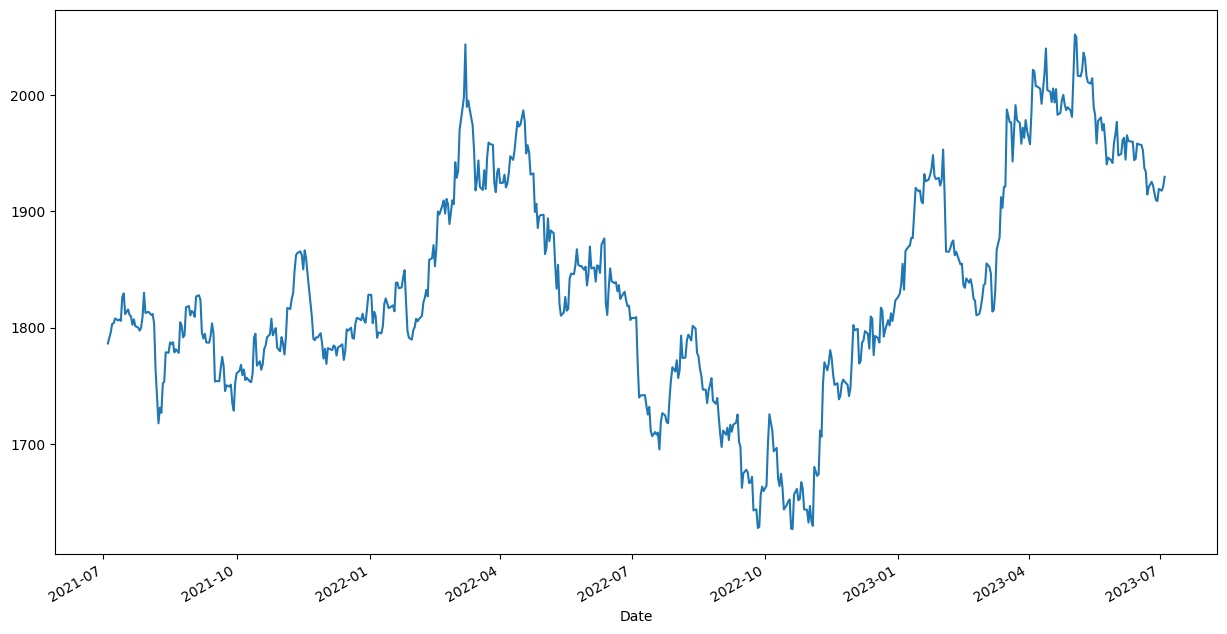

In [16]:
df3['Close'].plot(figsize=(15,8))

<Axes: xlabel='Date'>

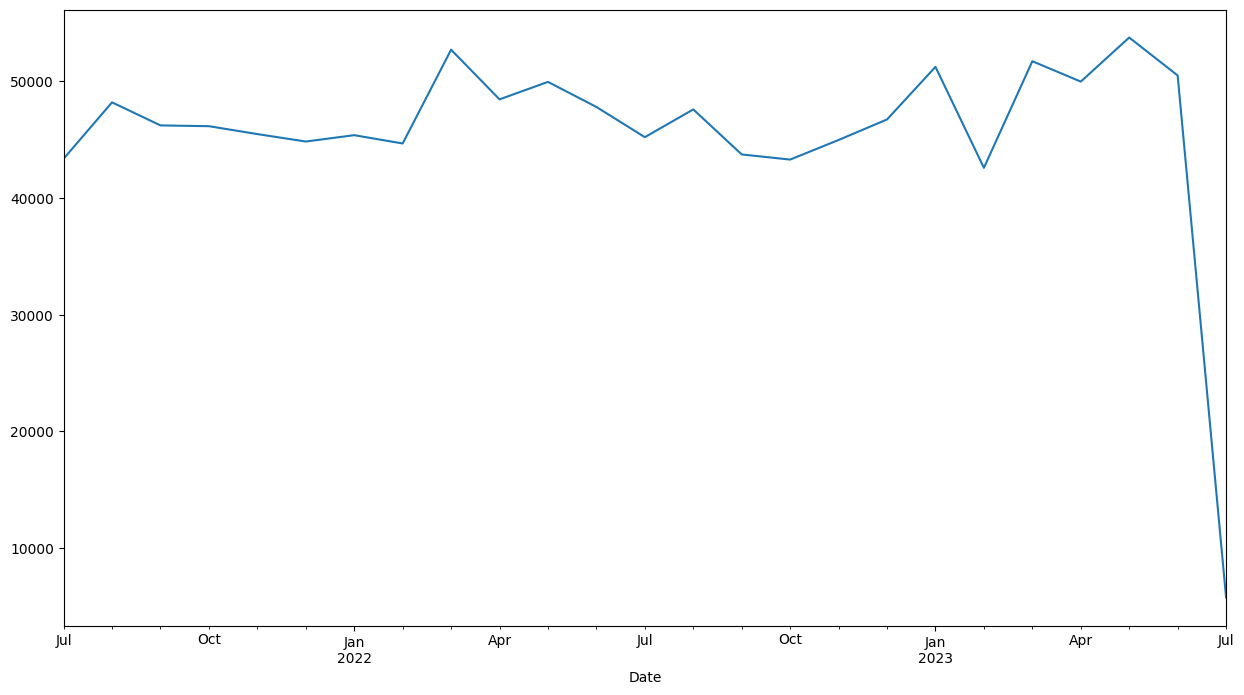

In [17]:
df3['Close'].resample("M").sum().plot(figsize=(15,8))

### Seasonal Decompose

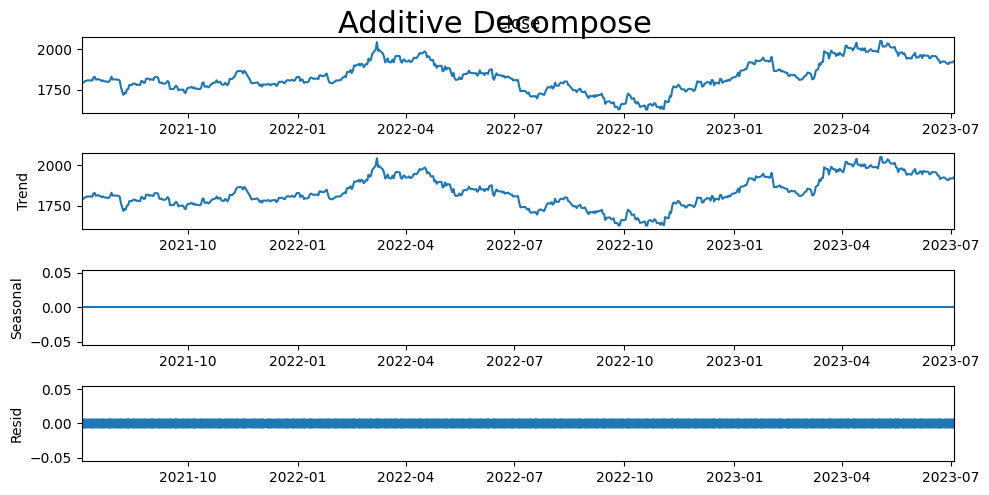

In [18]:
result_add = seasonal_decompose(x=df3['Close'], model='additive', extrapolate_trend='freq', period=1)
plt.rcParams.update({'figure.figsize': (10,5)})
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()

<div style="background-color:#d5eae9; padding:20px; font-size:15px">
<h1>ARIMA and Stationary Data </h1><p></P>
In an autoregressive integrated moving average model, the data are differenced in order to make it stationary. A model that shows stationarity is one that shows there is constancy to the data over time. Most economic and market data show trends, so the purpose of differencing is to remove any trends or seasonal structures. 

Seasonality, or when data show regular and predictable patterns that repeat over a calendar year, could negatively affect the regression model. If a trend appears and stationarity is not evident, many of the computations throughout the process cannot be made and produce the intended results.


### Important :
A one-time shock will affect subsequent values of an ARIMA model infinitely into the future. Therefore, the legacy of the financial crisis lives on in today’s autoregressive models.

## Stationarity check

In [19]:
adftest=adfuller(df3["Close"].dropna())
print(" adfuller test is : ",adftest[0])
print("pvalue of adfuller test is : ",adftest[1])

 adfuller test is :  -1.8512425385035889
pvalue of adfuller test is :  0.35533399855974857


In [20]:
adftest=adfuller(df3['Close'].diff().dropna())
print(" adfuller test is : ",adftest[0])
print("pvalue of adfuller test is : ",adftest[1])

 adfuller test is :  -19.11633435147595
pvalue of adfuller test is :  0.0


<div style="background-color:#d5eae9; padding:20px; font-size:15px">
<h1>ARIMA Parameters </h1><p></P>
Each component in ARIMA functions as a parameter with a standard notation. For ARIMA models, a standard notation would be ARIMA with p, d, and q, where integer values substitute for the parameters to indicate the type of ARIMA model used. The parameters can be defined as:

###### p: the number of lag observations in the model, also known as the lag order.
###### d: the number of times the raw observations are differenced; also known as the degree of differencing.
###### q: the size of the moving average window, also known as the order of the moving average.

## Autocorrelations Function (AFC)

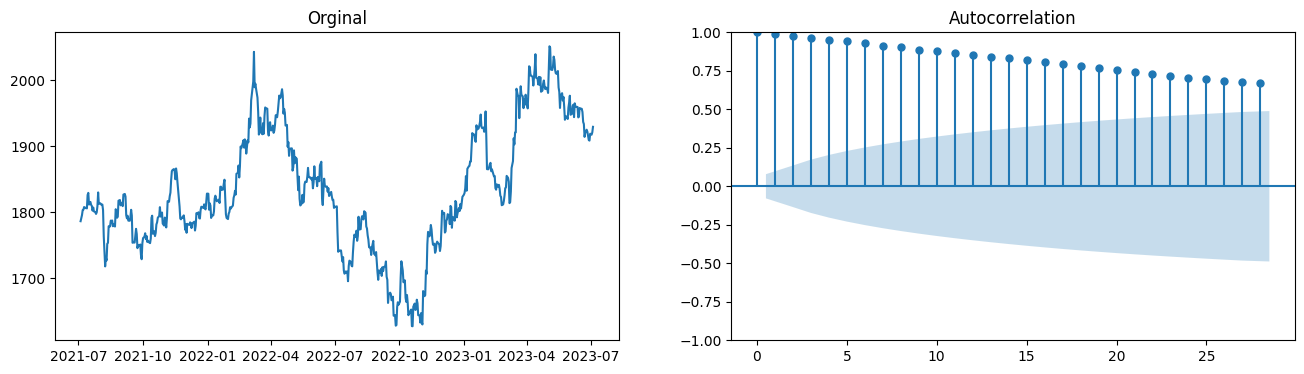

In [22]:


fig,(ax1,ax2)=plt.subplots(1,2,figsize=(16,4))
ax1.plot(df3.Close)
ax1.set_title("Orginal")
plot_acf(df3.Close,ax=ax2)

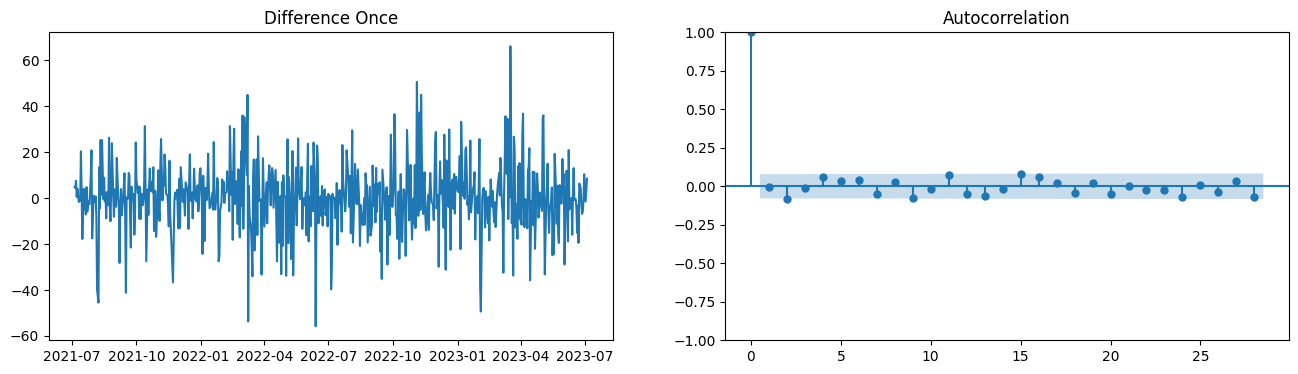

In [24]:
diff=df3['Close'].diff().dropna()
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(16,4))
ax1.plot(diff)
ax1.set_title("Difference Once")
plot_acf(diff,ax=ax2)

### p

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


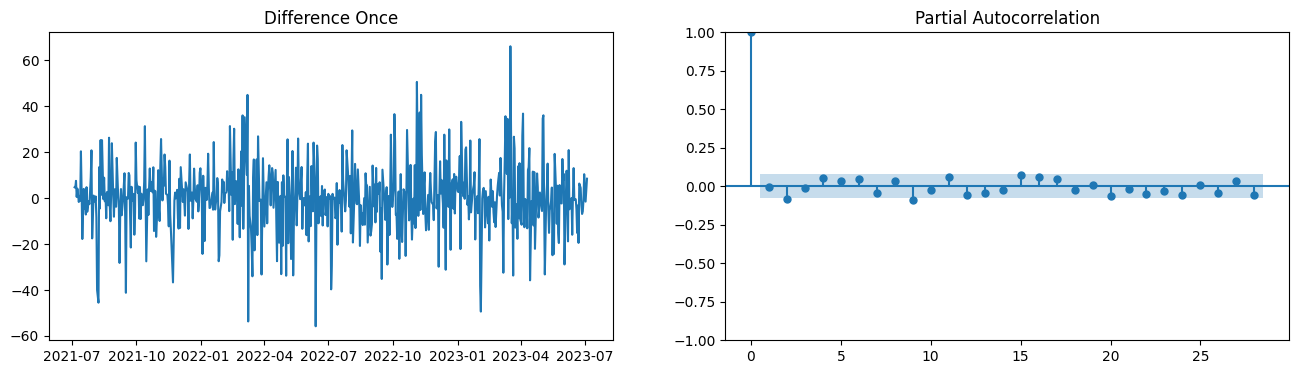

In [26]:

diff=df3['Close'].diff().dropna()
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(16,4))
ax1.plot(diff)
ax1.set_title("Difference Once")
ax2.set_ylim(0,1)
plot_pacf(diff,ax=ax2)


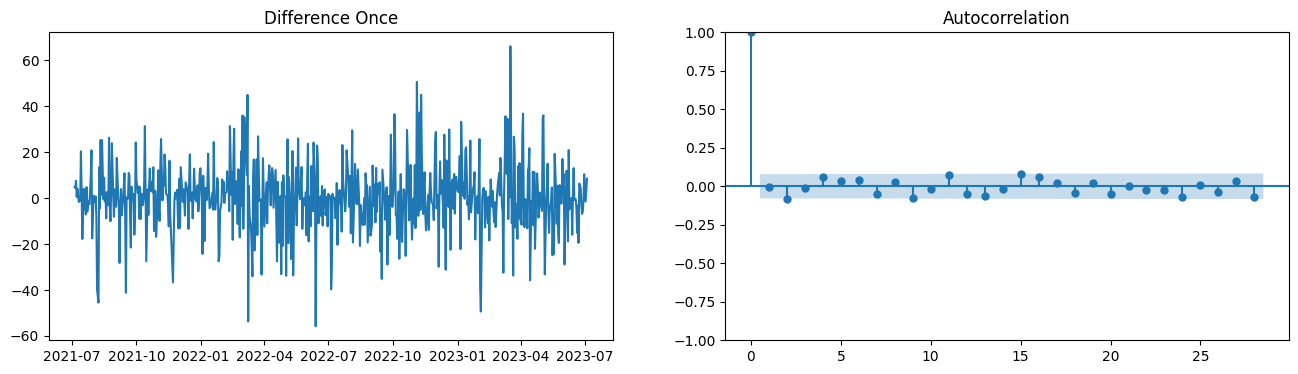

In [28]:
diff=df3.Close.diff().dropna()
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(16,4))
ax1.plot(diff)
ax1.set_title("Difference Once")
ax2.set_ylim(0,1)
plot_acf(diff,ax=ax2);


In [29]:
!pip3 install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 21.7 MB/s eta 0:00:00


# ARIMA model

<div style="background-color:#d5eae9; padding:20px; font-size:15px">
<h1>How to Build an ARIMA Model </h1><p></P>

To begin building an ARIMA model for an investment, you download as much of the price data as you can. Once you've identified the trends for the data, you identify the lowest order of differencing (d) by observing the autocorrelations. If the lag-1 autocorrelation is zero or negative, the series is already differenced. You may need to difference the series more if the lag-1 is higher than zero.
1

Next, determine the order of regression (p) and order of moving average (q) by comparing autocorrelations and partial autocorrelations. Once you have the information you need, you can choose the model you'll use.

In [ ]:
!pip3 install pmdarima

Defaulting to user installation because normal site-packages is not writeable


In [55]:


fit_arima = auto_arima(df3, d=1, start_p=1, star_q=1, max_p=15, max_q=11,
                      seasonal=True,
                      m=6,
                      D=1,
                      start_P=1,
                      start_Q=1,
                      max_P=15,
                      max_Q=11,
                      information_criterion='aic',
                      trace=True,
                      error_action='ignore',
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,2)(1,1,1)[6]             : AIC=inf, Time=2.40 sec
 ARIMA(0,1,0)(0,1,0)[6]             : AIC=5464.036, Time=0.08 sec
 ARIMA(1,1,0)(1,1,0)[6]             : AIC=5326.706, Time=0.45 sec
 ARIMA(0,1,1)(0,1,1)[6]             : AIC=inf, Time=2.16 sec
 ARIMA(1,1,0)(0,1,0)[6]             : AIC=5466.032, Time=0.15 sec
 ARIMA(1,1,0)(2,1,0)[6]             : AIC=5263.542, Time=0.56 sec
 ARIMA(1,1,0)(3,1,0)[6]             : AIC=5234.984, Time=1.14 sec
 ARIMA(1,1,0)(4,1,0)[6]             : AIC=5203.052, Time=1.91 sec
 ARIMA(1,1,0)(5,1,0)[6]             : AIC=5174.840, Time=1.67 sec
 ARIMA(1,1,0)(6,1,0)[6]             : AIC=5166.025, Time=2.00 sec
 ARIMA(1,1,0)(7,1,0)[6]             : AIC=5159.409, Time=3.54 sec
 ARIMA(1,1,0)(8,1,0)[6]             : AIC=5143.700, Time=6.34 sec
 ARIMA(1,1,0)(9,1,0)[6]             : AIC=5135.820, Time=6.49 sec
 ARIMA(1,1,0)(10,1,0)[6]             : AIC=5134.448, Time=13.16 sec
 ARIMA(1,1,0)(11,1,0)[6]             : AI

In [58]:

model=SARIMAX(df3,order=(0,1,0), seasonal_order=(10, 1, 0, 6))
result_sarimax = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [59]:
result_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Close   No. Observations:                  622
Model:             SARIMAX(0, 1, 0)x(10, 1, 0, 6)   Log Likelihood               -2555.247
Date:                            Wed, 12 Jul 2023   AIC                           5132.495
Time:                                    01:33:51   BIC                           5181.133
Sample:                                         0   HQIC                          5151.408
                                            - 622                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L6       -0.8723      0.036    -24.303      0.000      -0.943      -0.802
ar.S.L12      -0.8289      0.046    -17.859      0.000      -0.920      -0.738
ar.S.L18      -0.7716      0.059    -13.124      0.000      -0.887      -0.656
ar.S.L24      -0.7442      0.062    -11.987      0.000      -0.866      -0.623
ar.S.L30      -0.6482      0.065     -9.949      0.000      -0.776      -0.521
ar.S.L36      -0.5043      0.064     -7.820      0.000      -0.631      -0.378
ar.S.L42      -0.4203      0.066     -6.371      0.000      -0.550      -0.291
ar.S.L48      -0.3451      0.063     -5.494      0.000      -0.468      -0.222
ar.S.L54      -0.1964      0.054     -3.611      0.000      -0.303      -0.090
ar.S.L60      -0.0772      0.041     -1.864      0.062      -0.158       0.004
sigma2       233.8923     10.526     22.220      0.000     213.262     254.523
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                58.18
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               1.32   Skew:                            -0.02
Prob(H) (two-sided):                  0.04   Kurtosis:                         4.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Prediction

In [74]:
prediction = result_sarimax.get_prediction(start=-200)
prediction_media = prediction.predicted_mean

In [76]:
confidence_interval = prediction.conf_int()
limits_below = confidence_interval.iloc[:,0]
limits_above = confidence_interval.iloc[:,1]

limits_below[0], limits_above[0]

(1740.547918774258, 1800.4974894893653)

In [77]:
prediction_media[0]

1770.5227041318117

In [84]:
data_prev = np.asarray(predict_media.index)
data1 = np.asarray(df3.index)

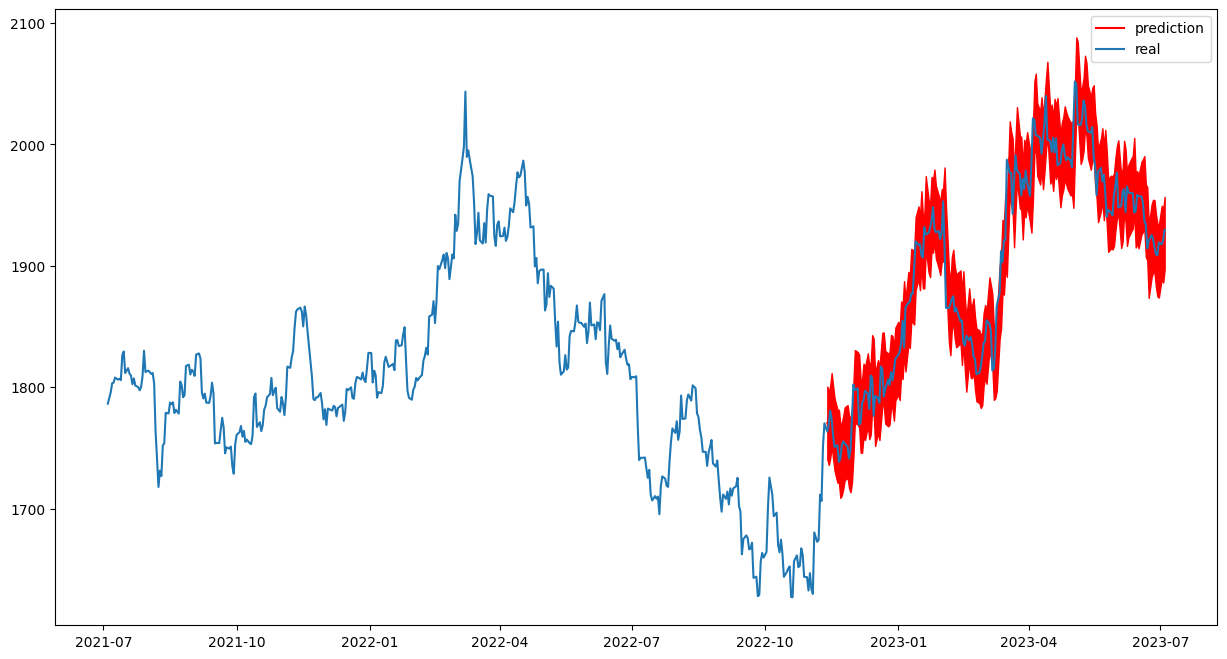

In [85]:
plt.figure(figsize=(15,8))
plt.plot(data_prev,prediction_media.values,color='red',label='prediction')
plt.fill_between(data_prev, limits_below, limits_above, color='red')
plt.plot(data1, df3.values, label='real')
plt.legend()
plt.show()

In [87]:

rmse_sarima = sqrt(mean_squared_error(df3[-200:].values,prediction_media.values))
print(rmse_sarima)

15.77913060429787


In [88]:
prediction_media

Date
2022-11-13    1770.522704
2022-11-14    1765.927414
2022-11-15    1771.259341
2022-11-16    1781.693785
2022-11-17    1771.120678
                 ...     
2023-06-29    1904.690849
2023-06-30    1903.819328
2023-07-02    1919.542417
2023-07-03    1916.158599
2023-07-04    1926.853861
Name: predicted_mean, Length: 200, dtype: float64

<div <h3 style="border-radius:10px;border:#034914 solid;padding: 15px;background-color:#d5eae9;font-size:90%;text-align:center"> </h3> 
        <h4 class="alert-heading">Thank you for taking the time to consider this matter</h4>
  <hr>
  <h4><b>Author:</b> Fatemeh Ebrahimikia </h4>